<img src='./img/logoline_12000.png' align='right' width='100%'></img>

<br>

# Bias correction of seasonal forecast data

### About

This notebook will show you how you can bias correct real-time seasonal forecasts of global sea surface temperature. 

#### Model errors
Seasonal forecasts are started from an observed state of (all components of) the climate system, which is then evolved in time over a period of a few months. Errors present at the start of the forecast (due to the imprecise measurement of the initial conditions and the approximations assumed in the formulation of the models) persist or, more often, grow through the model integration.

#### Biases and hindcasts
Some errors are random, some errors, however, are systematic. If these systematic errors were determined, corrections could be applied to the forecasts to extract the useful information. This is achieved by comparing retrospective forecasts (reforecasts or `hindcasts`) with observations. By building the average of the `hindcasts`, you can identify a 'climate' (average over a reference period, e.g 1993 to 2016) of the model, which can then be compared with the observed climate of the real world. The systematic differences between the model and the real world - usually referred to as `biases` - are thus quantified and used as the basis for corrections which can be applied to future, real-time forecasts.  Given the relative magnitude of such biases, some basic corrections are essential to convert the data into forecast information - therefore a forecast by itself is not useful without relating it to the relevant hindcasts.

To compute the real-world climate, the example below will make use of [ERA5 monthly averages on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview).

#### Bias correction
TBA



The notebook has the following outline:

* [1 - Compute the hindcast climate mean and variance for reference period 1993 to 2016](#hindcast_climate_mean_bias)
* [2 - Compute observation climate mean and variance from ERA5 monthly averages for reference period 1993 to 2016](#observation_climate_mean_bias)
* [3 - Load real-time seasonal forecast for September 2021 and five leadtime months](#load_realtime_forecast_bias)
* [4 - Visualize the bias between seasonal real-time forecast, model climate and observed climate](#visualize_bias)
* [5 - Correct the real-time seasonal forecast](#bias_correction)

### Data

This notebook makes use of `seasonal forecast monthly statistics` (hindcasts and real-time forecasts) and `ERA5 monthly averaged data` on single levels. The data used in the notebook has the following specifications:

<br>

> **Data**: `Seasonal forecast monthly statistics on single levels - Hindcast data` <br>
> **Temporal coverage**: `Sep 1993 to Sep 2016` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve requests**: 
> * [CDS API request - Hindcast individual members](./100_climate_data_store_intro.ipynb#seas5_monthly_hindcast)
> * [CDS API request - Hindcast climate mean](./100_climate_data_store_intro.ipynb#seas5_monthly_hindcast_mean)

<br>

> **Data**: `Seasonal forecast monthly statistics on single levels - Forecast data` <br>
> **Temporal coverage**: `Sep 2021` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#seas5_monthly_forecast)

<br>

> **Data**: `ERA5 monthly averaged data on single levels` <br>
> **Temporal coverage**: `Sep, Oct, Nov, Dec, Jan and Feb from 1993 to 2016` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#era5_monthly_seas5)

<br>

Get [here](./101_c3s_data_intro.ipynb#seasonal_forecasts) more information about seasonal forecast data in general including an overview of the different dataset types.

### Further resources

* [Seasonal forecasts and the Copernicus Climate Change Service](https://confluence.ecmwf.int/display/CKB/Seasonal+forecasts+and+the+Copernicus+Climate+Change+Service)

<br>

<hr>

### Load libraries

In [2]:
# CDS API
import cdsapi
import warnings

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

warnings.simplefilter(action = "ignore", category = RuntimeWarning)

<hr>

## <a id='hindcast_climate_mean_bias'></a>1. Compute the hindcast climate mean and variance for reference period 1993 to 2016

The first step is load the global hindcast data for September from 1993 to 2016 and calculate the `mean` and `variance` of the hindcast climate, based on the reference period 1993 to 2016. 

The seasonal forecasts monthly statistics are available in the data format `GRIB`, which can be opened with the Python package [xarray](http://xarray.pydata.org/en/stable/) and the function `open_dataset()`. In order to be able to open `GRIB` file, you have to specify the keyword argument `engine='cfgrib'`, which makes use of [cfgrib](https://github.com/ecmwf/cfgrib), a Python interface to map GRIB to the NetCDF Common Data model.

You can specify a custom data structure by identifying the keyword argument `backend_kwargs` and specifically highligting the two dimensions that shall be used for the time dimensions. When you do this, you see that the resulting `xarray.Dataset` has five dimensions:
* `number`: Number of ensembles (25)
* `forecastMonth`: leadtime months (6, including the startime run)
* `time`: number of years (24, from 1993 to 2016)
* `latitude`: latitudes (181 -> 1 deg resolution)
* `longitude`: longitudes (360 --> 1 deg resolution)

In [3]:
ds_hindcast = xr.open_dataset('./data/ecmwf_seas5_1993-2016_09_hindcast_monthly_sst.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
ds_hindcast

<xarray.Dataset>
Dimensions:        (number: 25, forecastMonth: 6, time: 24, latitude: 181, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-09-01 1994-09-01 ... 2016-09-01
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    sst            (number, forecastMonth, time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-18T15:50 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

The next step is to load the data variable `sst` as `xarray.DataArray`. You can load a DataArray from a Dataset by specifying the name of the variable in square brackets `[]`. A `xarray.DataArray` provides you additional attributes of the variable. For example, you see that the sea surface temperature is provided in the unit `Kelvin`.

In [4]:
sst_hindcast = ds_hindcast['sst']
sst_hindcast

<xarray.DataArray 'sst' (number: 25, forecastMonth: 6, time: 24, latitude: 181, longitude: 360)>
[234576000 values with dtype=float32]
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-09-01 1994-09-01 ... 2016-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes: (12/30)
    GRIB_paramId:                             34
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           sst
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

<br>

Since we are interested in creating the `hindcast climate mean`, the next step is to create the average over the 25 ensemble members and the 24 start years. You can use the function `mean()` in order to average over one or more given dimensions. The dimension we want to create the longterm mean are `number` (25 ensemble members) and `time` (start time years from 1993 to 2016). The result is a `xarray.DataArray` with three dimensions: `forecastMonth`, `latitude` and `longitude`.

The DataArray `tprate_hindcast_mean` is the hindcast climate mean for the month September and five leadtime months, over the reference period 1993 to 2016.

**Note:** with the averaging operation, your `xarray.DataArray` loses its attributes. At the end, we will again add the attributes.

In [5]:
sst_hindcast_mean = sst_hindcast.mean(['number', 'time'])
sst_hindcast_mean

<xarray.DataArray 'sst' (forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[271.38278, 271.38278, 271.38278, ..., 271.38278, 271.38278,
         271.38278],
        [271.3829 , 271.383  , 271.38315, ..., 271.3826 , 271.38266,
         271.38284],
        [271.38742, 271.38782, 271.38818, ..., 271.3865 , 271.38678,
         271.38702],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.34988, 271.34988, 271.34988, ..., 271.34988, 271.34988,
         271.34988],
        [271.35007, 271.35013, 271.35013, ..., 271.35007, 271.35007,
         271.35007],
        [271.35056, 271.35056, 271.35056, ..., 271.35056, 271.3506 ,
         271.3506 ],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.34967, 271.34967, 271.34967, ..., 271.34967, 271.34967,
         271.34967],
        [271.34967, 271.34967, 271.34967, ..., 271.34967, 271.34967,
         271.34967],
        [271.34967, 271.34967, 271.34967, ..., 271.34967, 271.34967,
         271.34967],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

<br>

The next step is also to calculate the variance of the hindcast climate mean. Instead of the function `mean()`, we can use the function `var()`, which computes the variance over the 25 ensemble members and the 24 start years. The resulting xarray.DataArray `sst_hindcast_variance` has three dimensions: `forecastMonth`, `latitude` and `longitude`. We will need the variance later on when we correct the bias of the forecast data.

In [70]:
sst_hindcast_variance = sst_hindcast.var(['number', 'time'])
sst_hindcast_variance

<xarray.DataArray 'sst' (forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[1.9864733e-03, 1.9864733e-03, 1.9864733e-03, ...,
         1.9864733e-03, 1.9864733e-03, 1.9864733e-03],
        [2.0455327e-03, 2.0600969e-03, 2.0772023e-03, ...,
         1.9969535e-03, 2.0109811e-03, 2.0267235e-03],
        [2.5749102e-03, 2.6136623e-03, 2.6538339e-03, ...,
         2.4352488e-03, 2.4787856e-03, 2.5270651e-03],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[4.9087776e-06, 4.9087776e-06, 4.9087776e-06, ...,
         4.9087776e-06, 4.9087776e-06, 4.9087776e-06],
        [8.8985144e-06, 8.7972858e-06, 8.7369854e-06, ...,
         8.8633469e-06, 8.8252000e-06, 8.9112300e-06],
        [2.9411360e-05, 2.8977536e-05, 2.8974557e-05, ...,
         2.9754205e-05, 2.9549599e-05, 2.9670397e-05],
...
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[3.7252903e-09, 3.7252903e-09, 3.7252903e-09, ...,
         3.7252903e-09, 3.7252903e-09, 3.7252903e-09],
        [3.7252903e-09, 3.7252903e-09, 3.7252903e-09, ...,
         3.7252903e-09, 3.7252903e-09, 3.7252903e-09],
        [3.7252903e-09, 3.7252903e-09, 3.7252903e-09, ...,
         3.7252903e-09, 3.7252903e-09, 3.7252903e-09],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

We have now loaded and computed the hindcast climate mean. The next step is to calculate the climate mean from observations, which is used as the observation climate mean.

<br>

## <a id='observation_climate_mean_bias'></a>2. Compute observation climate mean and variance from ERA5 monthly averages for reference period 1993 to 2016

The second step is to compute the climate mean and variance from observations, for the same reference period, from 1993 to 2016. As observation data, we make use of ERA5 monthly averages on single levels.
ERA5 data is a reanalysis and the data structure differs from seasonal forecast data. Instead of leadtime months, we select monthly averages for the months September to February for each year, from 1993 to 2016. See [here](./100_data_store_intro.ipynb#era5_monthly_seas5) the CDS data request used to download the ERA5 monthly averages in GRIB format. You can use the function `open_dataset()` together with the keyword argument `engine='cfgrib'` to open the GRIB file. Here, you do not have to specify specific keys to load, as reanalysis data do not have two time dimensions. If you load the GRIB file, you see that the data is structure in three dimensions: 
* `time`: 144 entries for months Jan, Feb, Sep, Oct, Nov, Dec from 1993 to 2016
* `latitude`: latitude (721 --> 0.25 deg)
* `longitude`: longitude (1440 --> 0.25 deg)

In [8]:
ds_observation = xr.open_dataset('./data/era5_monthly_1993-2016_sep-feb_sst.grib', engine='cfgrib')
ds_observation

Ignoring index file './data/era5_monthly_1993-2016_sep-feb_sst.grib.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:     (time: 144, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] ...
Data variables:
    sst         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-18T16:25 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

The next step is to load from the dataset above the data variable `sst` as xarray.DataArray. You simply add the name of the data variable in square brackets `[]`.

In [10]:
sst_observation = ds_observation['sst']
sst_observation

<xarray.DataArray 'sst' (time: 144, latitude: 721, longitude: 1440)>
[149506560 values with dtype=float32]
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
Attributes: (12/29)
    GRIB_paramId:                             34
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_name:                                Sea surface temperature
    GRIB_shortName:                           sst
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

<br>

The next step is now to create the average for each month for the reference period. You can use the function `group_by()` to specify the dimension you would to build groups from. In the present example, we want to build groups for each month in the `time` dimension. With the function `mean()` you can apply an aggregator function on the defined groups. The resulting data array has three dimensions, but the dimension `time` which has previously 144 entries changed to `month` with six entries.

In [11]:
sst_observation_mean = sst_observation.groupby('time.month').mean()
sst_observation_mean

<xarray.DataArray 'sst' (month: 6, latitude: 721, longitude: 1440)>
array([[[271.4601 , 271.4601 , 271.4601 , ..., 271.4601 , 271.4601 ,
         271.4601 ],
        [271.4601 , 271.46008, 271.4601 , ..., 271.4601 , 271.4601 ,
         271.4601 ],
        [271.4601 , 271.4601 , 271.4601 , ..., 271.46008, 271.4601 ,
         271.4601 ],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        [271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        [271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.45993, 271.45993, 271.45993, ..., 271.45993, 271.45993,
         271.45993],
        [271.45993, 271.45993, 271.45993, ..., 271.45993, 271.45993,
         271.45993],
        [271.45993, 271.45993, 271.45993, ..., 271.45993, 271.45993,
         271.45993],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 00:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * month      (month) int64 1 2 9 10 11 12

<br>

Let us repeat the same procedure as above, but instead of the average, let us compute the variance with the function `var()`. We will need the variance later on when we correct the bias of the forecast data.

In [69]:
sst_observation_var = sst_observation.groupby('time.month').var()
sst_observation_var

<xarray.DataArray 'sst' (month: 6, latitude: 721, longitude: 1440)>
array([[[7.97832982e-08, 7.97832982e-08, 7.97832982e-08, ...,
         7.97832982e-08, 7.97832982e-08, 7.97832982e-08],
        [7.97832982e-08, 6.95387499e-08, 7.97832982e-08, ...,
         7.97832982e-08, 7.97832982e-08, 7.97832982e-08],
        [7.97832982e-08, 7.97832982e-08, 7.97832982e-08, ...,
         1.09275184e-07, 7.97832982e-08, 7.97832982e-08],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[8.44399111e-08, 8.44399111e-08, 8.44399111e-08, ...,
         8.44399111e-08, 8.44399111e-08, 8.44399111e-08],
        [8.44399111e-08, 8.44399111e-08, 8.44399111e-08, ...,
         8.44399111e-08, 8.44399111e-08, 8.44399111e-08],
        [8.44399111e-08, 8.44399111e-08, 8.44399111e-08, ...,
         8.44399111e-08, 8.44399111e-08, 8.44399111e-08],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[6.86074273e-08, 6.86074273e-08, 6.86074273e-08, ...,
         6.86074273e-08, 6.86074273e-08, 6.86074273e-08],
        [6.86074273e-08, 6.86074273e-08, 6.86074273e-08, ...,
         6.86074273e-08, 6.86074273e-08, 6.86074273e-08],
        [6.86074273e-08, 6.86074273e-08, 6.86074273e-08, ...,
         6.86074273e-08, 6.86074273e-08, 6.86074273e-08],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 00:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * month      (month) int64 1 2 9 10 11 12

Now, we have also loaded and computed the climate mean and variance of the ERA5 observation data. The next is now to load real-time seasonal forecast dat for September 2021 and five leadtime months.

<br>

## <a id='load_realtime_forecast_bias'></a>3. Load real-time seasonal forecast for September 2021 and five leadtime months

The next step is now to load real-time seasonal forecasts for September 2021 and five leadtime months till February 2021. We open the dataset `ecmwf_seas5_2021_09_forecast_monthly_sst.grib` with the xarray function `open_dataset()`, where we again specify the two keyword arguments `engine` and `backend_kwargs`. See [here](.100_climate_data_store_intro.ipynb#seas5_monthly_forecast) the CDS API data request used.

Once the `xarray.Dataset` is loaded, you see that it has 4 dimensions:
* `number`: 51 ensemble members
* `forecastMonth`: 6 leadtime months, including September, the month of the model run
* `latitude`: latitude values
* `longitude`: longitude values

Compared to the hindcast data, we do not have the dimension `time`, as the data only holds information for the year 2021. Another difference is that seasonal forecast real-time data have 51 ensemble members, compared to hindcasts, who only have 25 ensemble members.

In [14]:
ds_forecast = xr.open_dataset('./data/ecmwf_seas5_2021_09_forecast_monthly_sst.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
ds_forecast

<xarray.Dataset>
Dimensions:        (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] ...
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    sst            (number, forecastMonth, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-18T16:28 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

Now, let us load the data variable `sst` as xarray.DataArray from the loaded dataset above.

In [15]:
sst_forecast = ds_forecast['sst']
sst_forecast

<xarray.DataArray 'sst' (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)>
[19938960 values with dtype=float32]
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes: (12/30)
    GRIB_paramId:                             34
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           sst
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

The next step is now to visualize the bias between seasonal real-time forecast, model climate and observed climate.

<br>

## <a id='visualize_bias'></a>4. Visualize the bias between seasonal real-time forecast, model climate and observed climate

Now, we have all the data we need to assess the bias of the forecast loaded and prepared:
* `sst_observation_mean`: the average conditions *observed* during the months Sep to Feb
* `sst_hindcast_mean`: the model climate during the monts Sep to Feb
* `sst_forecast`: the seasonal forecast for Sep 2021 and 5 leadtime months

The next step is to visually represent the bias. This representation will help us to better understand whether the the model produces a cold (underpredicts) or warm bias (overpredicts). Let us investigate the bias for the global sea surface temperature. As a first step, we have to create the global average of all three data arrays and convert it to a `pandas.DataFrame`.



#### Create a dataframe of the model climate of global sea surface temperatures

You can use the aggregation function `mean()` again to create the global average, but this time you want to average over both geographical coordinates, `latitude` and `longitude`. Let us create the global the model climate (`sst_hindcast_mean`). If you average over the two dimensions `latitude` and `longitude`, there is only the dimension `forecastMonth` remaining. The model climate has a total of six values and gives us for each month from September to February the average global sea surface temperature computed by the model.

In [19]:
model_climate_global = sst_hindcast_mean.mean(['latitude', 'longitude'])
model_climate_global

<xarray.DataArray 'sst' (forecastMonth: 6)>
array([287.05972, 286.80093, 286.6312 , 286.7019 , 286.93942, 287.1001 ],
      dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 0.0

<br>

The function `to_dataframe()` transforms a `xarray.DataArray` into a `pandas.DataFrame`. This structure is easier to plot time-series information. If we tranform the six values of the model climate, you see that the resulting data frame has six row entries and two columns, `surface` and `sst`.

In [20]:
model_climate_global_df = model_climate_global.to_dataframe()
model_climate_global_df

,surface,sst
forecastMonth,,
1,0.0,287.059723
2,0.0,286.800934
3,0.0,286.631195
4,0.0,286.701904
5,0.0,286.939423
6,0.0,287.100098


<br>

#### Create a dataframe of the observed climate mean of global sea surface temperature

The next step is now to repeate the procedure above also with the ERA5 observations. First, create the global sea surface temperature for each month by averaging over the two dimensions `latitude` and `longitude`. The result is a data array with one dimension (month) which has also six values. However, if you have a closer look at the dimensions `month`, the data naturally ordered following the sequence of the calendar. This means, values for January and February are followed by the values for September, October, November and December. Since the initial run of the seasonal forecasts is in September though, we have to align the sequence of the dimension `month` with the one from the observed climate.

In [29]:
observed_climate_global = sst_observation_mean.mean(['latitude', 'longitude'])
observed_climate_global

<xarray.DataArray 'sst' (month: 6)>
array([286.8457 , 286.97427, 287.08298, 286.78787, 286.6294 , 286.67624],
      dtype=float32)
Coordinates:
    number   int64 0
    step     timedelta64[ns] 00:00:00
    surface  float64 0.0
  * month    (month) int64 1 2 9 10 11 12

<br>

You can use the function `roll()` to reorganise a dimension of a `xarray.DataArray`. By specifying `month=4`, the entries of the `month` dimension are moved four times. By specifying the keyword argument `roll_coords=True`, we indicate that we also want the coordinates of the time dimension to be updated.

After the operation, you see that the six values of global sea surface temperature together with the `month` coordinate information have been re-arranged.

In [30]:
observed_climate_global_roll = observed_climate_global.roll(month=4, roll_coords=True)
observed_climate_global_roll

<xarray.DataArray 'sst' (month: 6)>
array([287.08298, 286.78787, 286.6294 , 286.67624, 286.8457 , 286.97427],
      dtype=float32)
Coordinates:
    number   int64 0
    step     timedelta64[ns] 00:00:00
    surface  float64 0.0
  * month    (month) int64 9 10 11 12 1 2

<br>

However, since we want to compare and visualize the observed climate mean with the model climate and the forecast values, it is advisable to modify the entries of the month dimension and align it with the ones from the model climate, which indicate the forecast months 1 to 6. You can use the function `assign_coords()` and reassign the values of the dimension `month`. The values you can take from the data array `model_climate_global`.

In [31]:
observed_climate_global_assigned = observed_climate_global_roll.assign_coords(month=model_climate_global.forecastMonth.values)
observed_climate_global_assigned

<xarray.DataArray 'sst' (month: 6)>
array([287.08298, 286.78787, 286.6294 , 286.67624, 286.8457 , 286.97427],
      dtype=float32)
Coordinates:
    number   int64 0
    step     timedelta64[ns] 00:00:00
    surface  float64 0.0
  * month    (month) int64 1 2 3 4 5 6

<br>

As a last step, we can convert the data array to a `pandas.DataFrame` with the function `to_dataframe()`. The dataframe has the same structure as the one for the model climate. We have six row entries (for each forecast month one) and the sea surface temperature values as one column. 
**Note:** the function `to_dataframe()` also creates a column for all additional coordinate information, e.g. step and surface. For our needs, we can leave it in the dataframe, but we will not use it.

In [32]:
observed_climate_global_df = observed_climate_global_assigned.to_dataframe()
observed_climate_global_df

,number,step,surface,sst
month,,,,
1,0,0 days,0.0,287.082977
2,0,0 days,0.0,286.787872
3,0,0 days,0.0,286.629395
4,0,0 days,0.0,286.676239
5,0,0 days,0.0,286.845703
6,0,0 days,0.0,286.974274


<br>

#### Create a dataframe of average global sea surface temperature from the seasonal real-time forecasts

Now, we also want to create the global average of the seasonal real-time forecast `sst_forecast`. When you apply the function `mean()`, you see that the resulting array has two remaining dimensions: `number` and `forecastMonth`.

In [25]:
sst_forecast_global = sst_forecast.mean(['latitude', 'longitude'])
sst_forecast_global

<xarray.DataArray 'sst' (number: 51, forecastMonth: 6)>
array([[287.27606, 287.00058, 286.80887, 286.85257, 287.04587, 287.20447],
       [287.3017 , 287.0359 , 286.82843, 286.90076, 287.0865 , 287.26144],
       [287.25244, 286.98578, 286.80087, 286.83804, 287.09576, 287.26846],
       [287.28278, 287.02054, 286.83115, 286.85812, 287.05707, 287.23514],
       [287.29837, 286.99866, 286.80682, 286.91107, 287.1549 , 287.3256 ],
       [287.28336, 287.01822, 286.81967, 286.86655, 287.11356, 287.26572],
       [287.28046, 287.0128 , 286.79556, 286.85034, 287.06122, 287.19852],
       [287.26688, 287.02502, 286.815  , 286.849  , 287.0888 , 287.25183],
       [287.2802 , 287.02798, 286.8273 , 286.8588 , 287.08078, 287.25305],
       [287.3109 , 287.012  , 286.82965, 286.87744, 287.07028, 287.24857],
       [287.27313, 287.01202, 286.82632, 286.8792 , 287.09534, 287.27866],
       [287.25443, 286.99554, 286.8091 , 286.83798, 287.08795, 287.23413],
       [287.30118, 287.01016, 286.81207, 286.8703 , 287.0765 , 287.25046],
       [287.28098, 287.01285, 286.80017, 286.91382, 287.18784, 287.37134],
       [287.29462, 287.0136 , 286.8348 , 286.8731 , 287.11   , 287.26288],
       [287.2844 , 287.00912, 286.8458 , 286.88065, 287.0611 , 287.24817],
       [287.2813 , 287.00006, 286.83456, 286.8756 , 287.08792, 287.2392 ],
       [287.29614, 287.00742, 286.84753, 286.9231 , 287.13202, 287.2774 ],
       [287.2442 , 286.9949 , 286.7961 , 286.85135, 287.0529 , 287.1875 ],
       [287.27075, 287.00687, 286.82806, 286.84396, 287.04327, 287.21964],
...
       [287.28403, 287.0167 , 286.81897, 286.86755, 287.07584, 287.2278 ],
       [287.26678, 287.02267, 286.80984, 286.80344, 287.0817 , 287.23358],
       [287.29532, 287.01773, 286.84045, 286.86237, 287.03534, 287.2055 ],
       [287.2853 , 287.03076, 286.87305, 286.88504, 287.13867, 287.26535],
       [287.28607, 287.0248 , 286.82364, 286.85532, 287.06   , 287.20935],
       [287.28394, 287.0393 , 286.84744, 286.91086, 287.05972, 287.17096],
       [287.28986, 287.0404 , 286.84286, 286.87357, 287.086  , 287.22644],
       [287.2703 , 286.9966 , 286.8214 , 286.83914, 287.07224, 287.21463],
       [287.29022, 287.04257, 286.90436, 286.95023, 287.16052, 287.3188 ],
       [287.28134, 287.02194, 286.80753, 286.85687, 287.0904 , 287.24573],
       [287.27466, 287.00436, 286.825  , 286.91727, 287.12726, 287.27368],
       [287.27216, 287.01578, 286.80212, 286.86142, 287.0807 , 287.25314],
       [287.2805 , 286.99942, 286.8125 , 286.8788 , 287.08154, 287.26385],
       [287.2754 , 287.02267, 286.8124 , 286.84402, 287.08826, 287.2403 ],
       [287.27902, 287.00287, 286.81946, 286.8663 , 287.12222, 287.2441 ],
       [287.26398, 287.00983, 286.8045 , 286.8398 , 287.03052, 287.16846],
       [287.28198, 287.0026 , 286.82358, 286.81732, 287.01743, 287.20795],
       [287.2956 , 287.00745, 286.81937, 286.92886, 287.0917 , 287.2618 ],
       [287.2947 , 287.02414, 286.8565 , 286.89478, 287.168  , 287.31967]],
      dtype=float32)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0

<br>

The aim is to have the six values of global sea surface temperature forecasts for each ensemble member. Let us try to convert the data array to a `pandas.DataFrame` with the function `to_dataframe()`. Now, the structure get a bit more complicated, as we have two dimensions (`number` and `forecastMonth`) the data have to be organised by. Let us drop any information we do not need, which are the coordinates `time` and `surface`. You can drop information from a `xarray.DataArray` with the function `drop_vars()`.

The result is a multi-index dataframe, with 306 row entries and 1 column. This is format not very handy to visualize together with the model and observed climate. For this reason, let us try in a next step to bring the data frame in a format that we have six row entries and each ensemble member represented as a column.

In [27]:
sst_forecast_global_df = sst_forecast_global.drop_vars(['surface','time']).to_dataframe(dim_order=['forecastMonth', 'number'])
sst_forecast_global_df

sst
forecastMonth number            
1             0       287.276062
              1       287.301697
              2       287.252441
              3       287.282776
              4       287.298370
...                          ...
6             46      287.244110
              47      287.168457
              48      287.207947
              49      287.261810
              50      287.319672

[306 rows x 1 columns]

<br>

Multi-index dataframe can be `unstacked`, which means that the multi-index is dissolved and the row entries of the second index (`ensemble members` in our case) are transposed and added as columns. You can unstack multi-index dataframes with the function `unstack()`. If you apply the function, the dataframe transforms into a structure we aimed for, 6 row entries and 51 column information representing the global sea surface temperature forecast of the ensemble members.

In [34]:
sst_forecast_global_df_final = sst_forecast_global_df.unstack()
sst_forecast_global_df_final

sst                                                  \
number                 0           1           2           3           4    
forecastMonth                                                               
1              287.276062  287.301697  287.252441  287.282776  287.298370   
2              287.000580  287.035889  286.985779  287.020538  286.998657   
3              286.808868  286.828430  286.800873  286.831146  286.806824   
4              286.852570  286.900757  286.838043  286.858124  286.911072   
5              287.045868  287.086487  287.095764  287.057068  287.154907   
6              287.204468  287.261444  287.268463  287.235138  287.325592   

                                                                           \
number                 5           6           7           8           9    
forecastMonth                                                               
1              287.283356  287.280457  287.266876  287.280212  287.310913   
2              287.018219  287.012787  287.025024  287.027985  287.011993   
3              286.819672  286.795563  286.815002  286.827301  286.829651   
4              286.866547  286.850342  286.848999  286.858795  286.877441   
5              287.113556  287.061218  287.088806  287.080780  287.070282   
6              287.265717  287.198517  287.251831  287.253052  287.248566   

               ...                                                  \
number         ...          41          42          43          44   
forecastMonth  ...                                                   
1              ...  287.281342  287.274658  287.272156  287.280487   
2              ...  287.021942  287.004364  287.015778  286.999420   
3              ...  286.807526  286.825012  286.802124  286.812500   
4              ...  286.856873  286.917267  286.861420  286.878815   
5              ...  287.090393  287.127258  287.080688  287.081543   
6              ...  287.245728  287.273682  287.253143  287.263855   

                                                                           \
number                 45          46          47          48          49   
forecastMonth                                                               
1              287.275391  287.279022  287.263977  287.281982  287.295593   
2              287.022675  287.002869  287.009827  287.002594  287.007446   
3              286.812408  286.819458  286.804504  286.823578  286.819366   
4              286.844025  286.866302  286.839813  286.817322  286.928864   
5              287.088257  287.122223  287.030518  287.017426  287.091705   
6              287.240295  287.244110  287.168457  287.207947  287.261810   

                           
number                 50  
forecastMonth              
1              287.294708  
2              287.024139  
3              286.856506  
4              286.894775  
5              287.167999  
6              287.319672  

[6 rows x 51 columns]

<br>

#### Visualize the bias of global sea surface temperature forecasts

Now, we can finally visualize the global sea surface temperature forecasts from September 2021 to February 2022 and compare the forecasts with the model climate and the observed climate. The matplotlib code for visualising the forecast bias can be split into four main parts:

* **1. Plot initiation**: Define size of the plot and initiate a subplot area with `plt.subplot()`

* **2. Plotting functions**: 
  * `plot()`: Time-series plot of model climate, observed climate and 51 ensemble of seasonal forecasts


* **3. Set labels and title**: Set name of x- and y-axis as well as title of the plot

* **4. Customize features**: Apply additional features to customized the style of the plot, e.g. size of x- and y-ticks or add gridlines

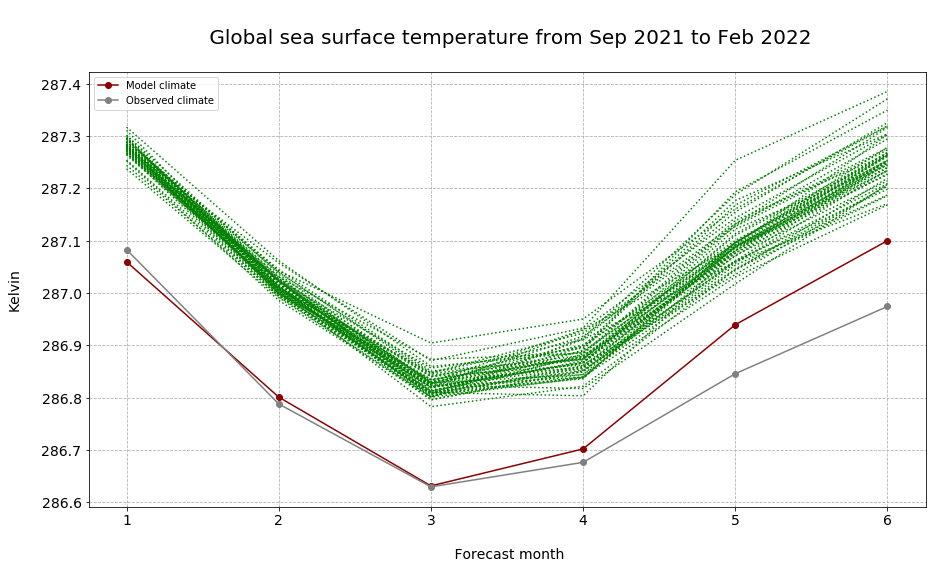

In [59]:
# Initiate a figure
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()

# Plot the model and obseved climate means of global sea surface temperature
ax.plot(model_climate_global_df.sst, 'bo-', color='darkred', label='Model climate')
ax.plot(observed_climate_global_df.sst, 'bo-', color='grey', label= 'Observed climate')
ax.legend(fontsize=16,loc=2)

# Plot the global sea surface temperature forecasts for the 51 ensemble members
sst_forecast_global_df_final.plot(ax=ax,
                             linestyle='dotted', color='green', legend=False, label='')



# Customize the title and axes lables
ax.set_title('\n Global sea surface temperature from Sep 2021 to Feb 2022\n', fontsize=20)
ax.set_ylabel('Kelvin\n', fontsize=14)
ax.set_xlabel('\n Forecast month', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a gridline to the plot
ax.grid(linestyle='--')

<br>

The graph above shows you the crucial role of hindcasts in seasonal forecasting. The grey line represents the average observed conditions and the red line represents the equivalent model climate average. The difference indicates a warm bias, which increases over time with the forecast. The ensemble forecasts are shown as green lines, which indicate even a stronger warm bias, compared to both, the model climate and the observed climate. This visual representation shows you that a forecast by itself is not useful without relating it to the relevant hindcasts.

In a next step, we can now correct the bias of the real-time seasonal forecast.

<br>

## <a id='bias_correction'></a>5. Correct the real-time seasonal forecast

In [81]:
sst_forecast_global_mean = sst_forecast_global.mean('number')
sst_forecast_global_mean

<xarray.DataArray 'sst' (forecastMonth: 6)>
array([287.28052, 287.0155 , 286.82498, 286.8739 , 287.0983 , 287.2571 ],
      dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0

In [86]:
sst_global_hindcast_variance = sst_hindcast_variance.mean({'latitude','longitude'})
sst_global_hindcast_variance

<xarray.DataArray 'sst' (forecastMonth: 6)>
array([0.3810578 , 0.35007286, 0.36123133, 0.40276533, 0.46396452,
       0.46282816], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 0.0

In [94]:
sst_global_observation_variance = sst_observation_var.mean({'latitude', 'longitude'})
sst_global_observation_variance_roll = sst_global_observation_variance.roll(month=4, roll_coords=True)

sst_global_observation_variance_roll

<xarray.DataArray 'sst' (month: 6)>
array([0.37050256, 0.30583563, 0.31268525, 0.35705718, 0.36334917,
       0.35334897], dtype=float32)
Coordinates:
    number   int64 0
    step     timedelta64[ns] 00:00:00
    surface  float64 0.0
  * month    (month) int64 9 10 11 12 1 2

<br>

The last step now is to correct the bias of the real-time seasonal forecast and

$ fcst* = (fcst - abs(hcst)) * var_{obs} / var_{hcst} + abs(obs) $

In [92]:
forecast_corrected = (sst_forecast_global_mean - abs(model_climate_global)) * (sst_global_observation_variance_roll.values/sst_global_hindcast_variance) + abs(observed_climate_global_assigned.values)
forecast_corrected

<xarray.DataArray 'sst' (forecastMonth: 6)>
array([287.29767, 286.97534, 286.79715, 286.8287 , 286.97012, 287.09415],
      dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0

<br>

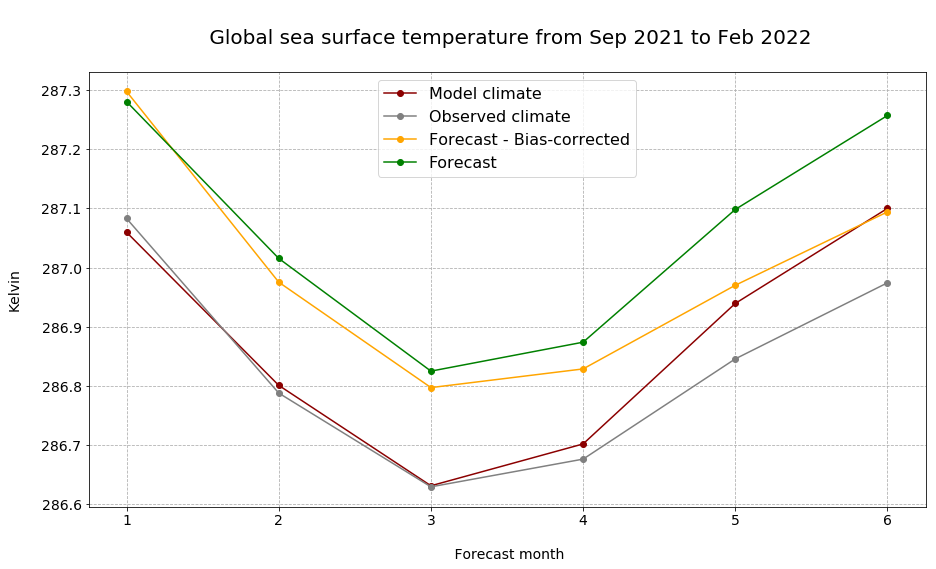

In [96]:
# Initiate a figure
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()

# Plot the model and obseved climate means of global sea surface temperature
ax.plot(model_climate_global_df.sst, 'bo-', color='darkred', label='Model climate')
ax.plot(observed_climate_global_df.sst, 'bo-', color='grey', label= 'Observed climate')
ax.plot(forecast_corrected.to_dataframe().sst, 'bo-', color='orange', label= 'Forecast - Bias-corrected')
ax.plot(sst_forecast_global_mean.to_dataframe().sst, 'bo-', color='green', label= 'Forecast')
ax.legend(fontsize=16,loc=0)





# Customize the title and axes lables
ax.set_title('\n Global sea surface temperature from Sep 2021 to Feb 2022\n', fontsize=20)
ax.set_ylabel('Kelvin\n', fontsize=14)
ax.set_xlabel('\n Forecast month', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a gridline to the plot
ax.grid(linestyle='--')

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>